# 数据读取

In [1]:
import os
from tqdm import tqdm 
import time

import numpy as np 
import pandas as pd 
import scipy
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn import preprocessing, metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.utils import shuffle# 随机排列
import gc
import lightgbm as lgb 
import joblib
from joblib import Parallel, delayed

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
train_path = '../data/eleme_round1_train/'
# test_path = '../data/eleme_round1_testA/'
test_path = '../data/eleme_round1_testB/'

In [4]:
# 读取数据并加入date列
def read_datafile(rootpath, section):
    file_path = rootpath + section + '/'
    data_list = []

    for f in os.listdir(file_path):
        date = f.split('.')[0].split('_')[1]
        if section == 'action':
            df = pd.read_csv(file_path+f,converters={'tracking_id':str})
        elif section == 'order':
            df = pd.read_csv(file_path+f,converters={'tracking_id':str})
        elif section == 'courier':
            df = pd.read_csv(file_path+f)
        elif section == 'distance':
            df = pd.read_csv(file_path+f,converters={'tracking_id':str, 'target_tracking_id':str})
        df['date'] = date
        data_list.append(df)
    
    return pd.concat(data_list)

In [5]:
def majorid(df):
    df['majorid'] = df['date'].map(str) + df['courier_id'].map(str) + '_' + df['wave_index'].map(str)
    return df

In [6]:
def dropdate(df):
    df.drop(['date', 'courier_id', 'wave_index'], axis=1, inplace=True)
    return df

In [7]:
# action的读取与处理
action_train = read_datafile(train_path, 'action')
action_test = read_datafile(test_path, 'action')

In [8]:
action_train = majorid(action_train)
action_test = majorid(action_test)

In [9]:
# groups = action_train.groupby(['majorid'])
# for name, group in tqdm(groups):
#     future_data = group.tail(int(group.shape[0] * 0.55))
#     last_data = group.drop(future_data.index)

#     # last_data['cost_time'] = 
#     break

In [10]:
# last_data.head()

In [11]:
# last_data['cost_time'] = last_data['expect_time'].apply(lambda row: (row[i+1]-row[i] for i in range(row)))
# last_data['expect_time'].apply(lambda row: last_data['expect_time'][row] ,axis=1)

In [12]:
def action_train_group(df):
    groups = df.groupby(['majorid'])
    df_future = []
    df_last = []
    for name, group in tqdm(groups):
        future_data = group.tail(int(group.shape[0] * 0.55))
        last_data = group.drop(future_data.index)

        # last操作，建立last_speed特征

        # last操作，提取last中最后一条
        last_data = last_data.tail(1)
        last_data.reset_index(drop=True, inplace=True)

        # 对future处理
        future_data['label'] = 0
        future_data.reset_index(drop=True, inplace=True)
        future_data.loc[0,'label'] = 1# 标记正负样本

        df_future.append(future_data)
        df_last.append(last_data)
    return_last = pd.concat(df_last)
    return_future = pd.concat(df_future)
    return_last.rename({'expect_time' : 'last_time'}, axis=1, inplace=True)# 把expecttime列重命名为last_time
    return_future = shuffle(return_future)# 随机打乱顺序

    return return_last, return_future

def action_test_group(df):
    groups = df.groupby(['majorid'])
    df_future = []
    df_last = []
    for name, group in tqdm(groups):
        future_data = group[group['expect_time']==0]
        last_data = group.drop(future_data.index)

        # last操作，建立last_speed特征

        # last操作
        last_data = last_data.tail(1)
        last_data.reset_index(drop=True, inplace=True)

        # future操作
        future_data['label'] = None

        df_future.append(future_data)
        df_last.append(last_data)
    return_last = pd.concat(df_last)
    return_future = pd.concat(df_future)
    return_last.rename({'expect_time' : 'last_time'}, axis=1, inplace=True)
    return return_last, return_future

In [13]:
action_train_thelast, action_train_future = action_train_group(action_train)
action_test_thelast, action_test_future = action_test_group(action_test)

100%|██████████| 4219/4219 [00:11<00:00, 355.69it/s]


In [14]:
# distance的读取与引入
distance_train = read_datafile(train_path, 'distance')
distance_test = read_datafile(test_path, 'distance')

In [15]:
distance_train = majorid(distance_train)
distance_test = majorid(distance_test)

In [16]:
rename_rule = {'source_type' : 'action_type'}

distance_test.rename(rename_rule, axis=1, inplace=True)
distance_train.rename(rename_rule, axis=1, inplace=True)

In [17]:
distance_train = dropdate(distance_train)
distance_test = dropdate(distance_test)

In [18]:
feature_train = pd.merge(left=action_train_thelast,right=distance_train, on=['majorid', 'tracking_id', 'action_type'], how='left')
feature_test = pd.merge(left=action_test_thelast,right=distance_test, on=['majorid', 'tracking_id', 'action_type'], how='left')

In [19]:
rename_rule = {'tracking_id':'last_tracking_id', 'action_type':'last_action_type', 'target_tracking_id':'tracking_id', 'target_type':'action_type'}

feature_test.rename(rename_rule, axis=1, inplace=True)
feature_train.rename(rename_rule, axis=1, inplace=True)

In [20]:
feature_test.drop(['courier_wave_start_lng', 'courier_wave_start_lat'],axis=1,inplace=True)
feature_train.drop(['courier_wave_start_lng', 'courier_wave_start_lat'],axis=1,inplace=True)
feature_train = dropdate(feature_train)
feature_test = dropdate(feature_test)

In [21]:
feature_train = pd.merge(left=action_train_future,right=feature_train, on=['majorid', 'tracking_id', 'action_type'], how='left')
feature_test = pd.merge(left=action_test_future,right=feature_test, on=['majorid', 'tracking_id', 'action_type'], how='left')

In [22]:
del action_test, action_test_future, action_test_thelast
del action_train, action_train_future, action_train_thelast
del distance_test, distance_train

In [23]:
# order的读取与引入
order_train = read_datafile(train_path, 'order')
order_test = read_datafile(test_path, 'order')

In [24]:
order_test = majorid(order_test)
order_train = majorid(order_train)

In [25]:
order_test = dropdate(order_test)
order_train = dropdate(order_train)

In [26]:
feature_test = pd.merge(left=feature_test, right=order_test, on=['majorid', 'tracking_id'], how='left')
feature_train = pd.merge(left=feature_train, right=order_train, on=['majorid', 'tracking_id'], how='left')

In [27]:
# courier的读取与引入
courier_train = read_datafile(train_path, 'courier')
courier_test = read_datafile(test_path, 'courier')

In [28]:
feature_test = pd.merge(left=feature_test, right=courier_test, on=['courier_id', 'date'], how='left')
feature_train = pd.merge(left=feature_train, right=courier_train, on=['courier_id', 'date'], how='left')

In [29]:
del courier_test, courier_train
del order_train, order_test

In [30]:
# 合并train和test集方便特征构造
## 使两集dtype一致
feature_test['label'] = 0

In [31]:
## 构造train列
feature_train['train'] = 1
feature_test['train'] = 0

In [37]:
## 合并
df_feature = feature_train.copy()
df_feature = df_feature.append(feature_test)

In [42]:
## 建立索引
df_feature['id'] = range(df_feature.shape[0])

In [44]:
df_feature.to_pickle('../user_data/temp_data/feature_01.pkl')

In [45]:
df_feature.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,source_lng,source_lat,target_lng,target_lat,grid_distance,weather_grade,pick_lng,pick_lat,deliver_lng,deliver_lat,create_time,confirm_time,assigned_time,promise_deliver_time,estimate_pick_time,aoi_id,shop_id,level,speed,max_load,train,id
0,102748698,3,2100074647966156746,121.564498,39.134533,DELIVERY,1580709664,20200203,20200203102748698_3,1,2100074647966156746,PICKUP,1580709535,121.572802,39.135679,121.571944,39.135241,137.000000,正常天气,121.572802,39.135679,121.571944,39.135241,1580709046,1580709048,1580709069,1580710906,1580709888,62f6a0332dd682041a7ba188e734fcc5,72379335a1793f870cc3f89d83f016d3,3,4.799916,11,1,0
1,118789185,7,2100075565715654469,121.476840,39.116818,PICKUP,1582449162,20200223,20200223118789185_7,0,2100075565242320182,DELIVERY,1582447815,121.487304,39.133041,121.475546,39.133848,1146.000000,正常天气,121.475546,39.133848,121.468194,39.147031,1582447981,1582447982,1582448035,1582451101,1582449242,2e4379c60ae9c17c89c5cb846fbf15be,062b3feb18db73cdd6fecbaf327fb62d,3,5.271828,6,1,1
2,118715465,8,2100075708210906615,121.770908,39.106027,DELIVERY,1582632894,20200225,20200225118715465_8,0,2100075710572463479,PICKUP,1582632203,121.774931,39.098821,121.801374,39.090041,3386.000000,正常天气,121.772343,39.106773,121.801374,39.090041,1582631139,1582631140,1582631329,1582634199,1582632400,ce3d8df4b762e710f0dfd3418f6f723c,ddb63ee61d20e7a3fd195f82175ec034,3,6.193977,8,1,2
3,118981753,3,2100075014758401829,121.701161,39.277405,DELIVERY,1581497342,20200212,20200212118981753_3,0,2100075012945905606,DELIVERY,1581494049,121.687104,39.279371,121.736264,39.236291,8996.852352,轻微恶劣天气,121.741248,39.246149,121.736264,39.236291,1581495721,1581495724,1581495873,1581498241,1581496984,e51c58804d1e10e3fbf7e54a31998aff,4b37d9792bd56a58d4283df0a4ecf208,3,5.306071,11,1,3
4,111751082,1,2100075548361262448,121.530035,39.206537,PICKUP,1582433734,20200223,20200223111751082_1,0,2100075545286345945,PICKUP,1582432245,121.536736,39.209886,121.545345,39.207985,922.000000,正常天气,121.545345,39.207985,121.524684,39.197251,1582432268,1582432270,1582432299,1582435268,1582433350,f54c4b17aa3c8c778d6dbab76d2a7ae0,fedbfff5a8f254596948102c81445c67,3,5.569951,11,1,4


In [46]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300054 entries, 0 to 19428
Data columns (total 35 columns):
courier_id                300054 non-null int64
wave_index                300054 non-null int64
tracking_id               300054 non-null object
courier_wave_start_lng    300054 non-null float64
courier_wave_start_lat    300054 non-null float64
action_type               300054 non-null object
expect_time               300054 non-null int64
date                      300054 non-null object
majorid                   300054 non-null object
label                     300054 non-null int64
last_tracking_id          300054 non-null object
last_action_type          300054 non-null object
last_time                 300054 non-null int64
source_lng                300054 non-null float64
source_lat                300054 non-null float64
target_lng                300054 non-null float64
target_lat                300054 non-null float64
grid_distance             300054 non-null float64
weathe

In [47]:
df_feature.columns

Index(['courier_id', 'wave_index', 'tracking_id', 'courier_wave_start_lng',
       'courier_wave_start_lat', 'action_type', 'expect_time', 'date',
       'majorid', 'label', 'last_tracking_id', 'last_action_type', 'last_time',
       'source_lng', 'source_lat', 'target_lng', 'target_lat', 'grid_distance',
       'weather_grade', 'pick_lng', 'pick_lat', 'deliver_lng', 'deliver_lat',
       'create_time', 'confirm_time', 'assigned_time', 'promise_deliver_time',
       'estimate_pick_time', 'aoi_id', 'shop_id', 'level', 'speed', 'max_load',
       'train', 'id'],
      dtype='object')

# 分类任务特征工程

In [48]:
import os
from tqdm import tqdm 
import time

import numpy as np 
import pandas as pd 
import scipy
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn import preprocessing, metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.utils import shuffle# 随机排列
import gc
import lightgbm as lgb 
import joblib
from joblib import Parallel, delayed

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [49]:
df_feature = pd.read_pickle('../user_data/temp_data/feature_01.pkl')

In [50]:
df_feature['rush'] = (df_feature['last_time']-df_feature['create_time']) / (df_feature['promise_deliver_time']-df_feature['create_time'])

In [51]:
# 加入剩余最短距离 和 删掉没pickup的delivery
new_feature = []
for name, group in tqdm(df_feature.groupby('majorid')):
    # 删除没pickup的delivery
    cant_delivery = pd.DataFrame(group['tracking_id'].value_counts())
    cant_delivery = cant_delivery[cant_delivery['tracking_id']>1].index
    group['cant_delivery'] = group.apply(lambda row: 1 if (row['tracking_id'] in cant_delivery)and(row['action_type']=='DELIVERY') else 0, axis=1)
    group = group[group['cant_delivery'] == 0]

    group.drop('cant_delivery', axis=1, inplace=True)
    new_feature.append(group)

    # 加入剩余最短距离

    # break
df_feature_new = pd.concat(new_feature)

100%|██████████| 86752/86752 [10:38<00:00, 135.96it/s]


In [52]:
df_feature_new.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,source_lng,source_lat,target_lng,target_lat,grid_distance,weather_grade,pick_lng,pick_lat,deliver_lng,deliver_lat,create_time,confirm_time,assigned_time,promise_deliver_time,estimate_pick_time,aoi_id,shop_id,level,speed,max_load,train,id,rush
130725,100002543,0,2100074542836254538,121.635755,39.141497,DELIVERY,1580520355,20200201,20200201100002543_0,1,2100074536706869066,PICKUP,1580519758,121.647214,39.135549,121.647324,39.126481,2782.0,正常天气,121.647214,39.135549,121.647324,39.126481,1580517517,1580517517,1580518968,1580521500,1580519017,a986694f4dd7e70ea73e2261889cde81,02615f185581167cc68ba41af3d25ce6,3,4.59264,10,1,130725,0.562641
231723,100002543,0,2100074536706869066,121.635755,39.141497,DELIVERY,1580520770,20200201,20200201100002543_0,0,2100074536706869066,PICKUP,1580519758,121.647214,39.135549,121.655694,39.123121,3503.0,正常天气,121.647214,39.135549,121.655694,39.123121,1580484067,1580484067,1580519088,1580521500,1580485567,4424963369d15e8900db6cfe732700c3,02615f185581167cc68ba41af3d25ce6,3,4.59264,10,1,231723,0.953464
23630,100002543,1,2100074546090674142,121.631040,39.137702,DELIVERY,1580525047,20200201,20200201100002543_1,1,2100074546118723550,PICKUP,1580524468,121.629701,39.139352,121.658144,39.135721,3156.0,正常天气,121.629701,39.139352,121.658144,39.135721,1580523657,1580523658,1580523709,1580526417,1580524558,4df9946bb92f495035be19576fd2d828,374469acda40b1b0b5d34ab4a58cb194,3,4.59264,10,1,23630,0.293841
91378,100002543,1,2100074546118723550,121.631040,39.137702,DELIVERY,1580525705,20200201,20200201100002543_1,0,2100074546118723550,PICKUP,1580524468,121.629701,39.139352,121.660584,39.130871,3488.0,正常天气,121.629701,39.139352,121.660584,39.130871,1580523868,1580523869,1580523889,1580526568,1580524589,1e774d8c07c353386658144a16dfd8c1,374469acda40b1b0b5d34ab4a58cb194,3,4.59264,10,1,91378,0.222222
161303,100002543,2,2100074572925863604,121.642295,39.135482,DELIVERY,1580550955,20200201,20200201100002543_2,1,2100074572925863604,PICKUP,1580550426,121.642437,39.135199,121.656294,39.122061,3260.0,正常天气,121.642437,39.135199,121.656294,39.122061,1580549262,1580549263,1580549269,1580551902,1580550163,e4bc0664f82df5c8491cbb9f5bd4abb0,9265cec8aa44dceae0072716a3a7e58a,3,4.59264,10,1,161303,0.440909


In [53]:
df_feature_new.to_pickle('../user_data/temp_data/feature_cls.pkl')

# 分类任务建模

In [55]:
import os
from tqdm import tqdm 
import time

import numpy as np 
import pandas as pd 
import scipy
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn import preprocessing, metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.utils import shuffle# 随机排列
import gc
import lightgbm as lgb 
import joblib
from joblib import Parallel, delayed

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [56]:
df_feature = pd.read_pickle('../user_data/temp_data/feature_cls.pkl')

In [57]:
seed = 2020

In [58]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214076 entries, 130725 to 19427
Data columns (total 36 columns):
courier_id                214076 non-null int64
wave_index                214076 non-null int64
tracking_id               214076 non-null object
courier_wave_start_lng    214076 non-null float64
courier_wave_start_lat    214076 non-null float64
action_type               214076 non-null object
expect_time               214076 non-null int64
date                      214076 non-null object
majorid                   214076 non-null object
label                     214076 non-null int64
last_tracking_id          214076 non-null object
last_action_type          214076 non-null object
last_time                 214076 non-null int64
source_lng                214076 non-null float64
source_lat                214076 non-null float64
target_lng                214076 non-null float64
target_lat                214076 non-null float64
grid_distance             214076 non-null float64
w

In [59]:
# 类别特征编码
for f in df_feature.select_dtypes('object'):
    if f not in ['tracking_id', 'last_tracking_id', 'date']:
        print(f)
        lbl = LabelEncoder()
        df_feature[f] = lbl.fit_transform(df_feature[f].astype(str))

action_type
majorid
last_action_type
weather_grade
aoi_id
shop_id


In [61]:
df_feature.columns

Index(['courier_id', 'wave_index', 'tracking_id', 'courier_wave_start_lng',
       'courier_wave_start_lat', 'action_type', 'expect_time', 'date',
       'majorid', 'label', 'last_tracking_id', 'last_action_type', 'last_time',
       'source_lng', 'source_lat', 'target_lng', 'target_lat', 'grid_distance',
       'weather_grade', 'pick_lng', 'pick_lat', 'deliver_lng', 'deliver_lat',
       'create_time', 'confirm_time', 'assigned_time', 'promise_deliver_time',
       'estimate_pick_time', 'aoi_id', 'shop_id', 'level', 'speed', 'max_load',
       'train', 'id', 'rush'],
      dtype='object')

In [60]:
df_test = df_feature[df_feature['train'] == 0].copy()
df_train = df_feature[df_feature['train'] == 1].copy()
df_train = shuffle(df_train, random_state=seed)

In [84]:
y_col = 'label'
x_col = [
    'weather_grade', 'aoi_id', 'shop_id', 'courier_id', 
    'source_lng', 'source_lat', 'target_lng', 'target_lat', 
    'last_time', 'create_time', 'promise_deliver_time', 'estimate_pick_time', 
    'speed', 'max_load', 'rush', 'grid_distance'
    ]

model = lgb.LGBMClassifier(num_leaves=64,
                           max_depth=10,
                           learning_rate=0.1,
                           n_estimators=10000000,
                           subsample=0.8,
                           feature_fraction=0.8,
                           reg_alpha=0.5,
                           reg_lambda=0.5,
                           random_state=seed,
                           metric=None
                           )


oof = []
prediction = df_test[['id', 'majorid']]
prediction['label'] = 0
df_importance_list = []

kfold = GroupKFold(n_splits=5)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[x_col], df_train[y_col], df_train['majorid'])):
    X_train = df_train.iloc[trn_idx][x_col]
    Y_train = df_train.iloc[trn_idx][y_col]

    X_val = df_train.iloc[val_idx][x_col]
    Y_val = df_train.iloc[val_idx][y_col]

    print('\nFold_{} Training ================================\n'.format(fold_id+1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=500,
                          eval_metric='auc',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(
        X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof = df_train.iloc[val_idx][['id', 'majorid', y_col]].copy()
    df_oof['pred'] = pred_val
    oof.append(df_oof)

    pred_test = lgb_model.predict_proba(
        df_test[x_col], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['label'] += pred_test / 5

    df_importance = pd.DataFrame({
        'column': x_col,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    joblib.dump(lgb_model, '../user_data/model_data/modelA_{}.dat'.format(fold_id))
    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()


Fold_1 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	train's auc: 0.840879	valid's auc: 0.781267

Fold_2 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	train's auc: 0.835855	valid's auc: 0.783622

Fold_3 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	train's auc: 0.827359	valid's auc: 0.783789

Fold_4 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	train's auc: 0.834049	valid's auc: 0.78344

Fold_5 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	train's auc: 0.840812	valid's auc: 0.782653


In [85]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg(
    'mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,rush,2261.4
1,grid_distance,1935.8
2,shop_id,1778.0
3,aoi_id,1636.2
4,target_lat,1282.8
5,target_lng,1236.0
6,source_lng,1175.0
7,speed,1164.0
8,source_lat,1134.6
9,courier_id,1109.0


In [76]:
def wave_label_func(group):
    target_list = group['label'].values.tolist()
    pred_list = group['pred'].values.tolist()
    max_index = pred_list.index(max(pred_list))
    if target_list[max_index] == 1:
        return 1
    else:
        return 0

In [86]:
df_oof = pd.concat(oof)
df_temp = df_oof.groupby(['majorid']).apply(wave_label_func).reset_index()
df_temp.columns = ['majorid', 'result']
acc = df_temp[df_temp['result'] == 1].shape[0] / df_temp.shape[0]
print('acc:', acc)

acc: 0.8104879260417045


In [89]:
def label_func(group):
    group = group.values.tolist()
    max_index = group.index(max(group))
    label = np.zeros(len(group))
    label[max_index] = 1
    return label


prediction['result'] = prediction.groupby(['majorid'])['label'].transform(label_func)
sub_part1 = prediction[prediction['result'] == 1]
df_oof = df_oof[df_oof['label'] == 1]
next_action = pd.concat([df_oof[['id']], sub_part1[['id']]])
next_action.to_csv('../user_data/temp_data/next_action.csv', index=False)

# 回归任务特征工程

In [94]:
import os
from tqdm import tqdm 
import time

import numpy as np 
import pandas as pd 
import scipy
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn import preprocessing, metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.utils import shuffle# 随机排列
import gc
import lightgbm as lgb 
import joblib
from joblib import Parallel, delayed

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [95]:
next_action = pd.read_csv('../user_data/temp_data/next_action.csv')

In [96]:
next_action.head()

,id
0,254012
1,47418
2,132140
3,77922
4,117391


In [97]:
df_feature = pd.read_pickle('../user_data/temp_data/feature_cls.pkl')
print(df_feature.shape)
df_feature = next_action.merge(df_feature, how='left')
print(df_feature.shape)

(214076, 36)
(86752, 36)


In [98]:
df_feature['train'].value_counts()

1    82533
0     4219
Name: train, dtype: int64

In [99]:
df_feature.head()

,id,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,source_lng,source_lat,target_lng,target_lat,grid_distance,weather_grade,pick_lng,pick_lat,deliver_lng,deliver_lat,create_time,confirm_time,assigned_time,promise_deliver_time,estimate_pick_time,aoi_id,shop_id,level,speed,max_load,train,rush
0,254012,10515102,0,2100075894604924701,121.523458,39.133308,DELIVERY,1582870205,20200228,2020022810515102_0,1,2100075894604924701,PICKUP,1582869970,121.531154,39.137572,121.529684,39.140121,387.0,正常天气,121.531154,39.137572,121.529684,39.140121,1582869637,1582869637,1582869679,1582871437,1582870537,4b032ad6db2a3132e0e57ff3231f9e24,c3c9ea1f444a997883e432b400507a1d,2,5.677057,10,1,0.185000
1,47418,110944498,0,2100075352680400741,121.677904,39.069170,DELIVERY,1582163835,20200220,20200220110944498_0,1,2100075352680400741,PICKUP,1582163268,121.678874,39.070310,121.664174,39.069571,1752.0,正常天气,121.678874,39.070310,121.664174,39.069571,1582132586,1582132587,1582162763,1582164900,1582154606,45f00cd55423c4d59156184e0d1193b6,0a2d2d2cd5eb246e6e20294db4cdcc8e,3,5.371323,9,1,0.949496
2,132140,100069773,5,2100074620752233977,121.559272,39.173702,DELIVERY,1580640942,20200202,20200202100069773_5,1,2100074619659945396,PICKUP,1580640307,121.546490,39.171249,121.552244,39.168591,1295.0,正常天气,121.546034,39.171984,121.552244,39.168591,1580639243,1580639244,1580639275,1580641583,1580640144,5f2f76ca37983e4ac39c3984da6d528f,d00f77a0471afb92e908c9ce93cc8c91,3,4.081472,11,1,0.454701
3,77922,114244561,4,2100075140308174839,121.361960,39.291729,PICKUP,1581750720,20200215,20200215114244561_4,1,2100075139650553390,DELIVERY,1581750171,121.358704,39.295851,121.362149,39.291649,1564.0,正常天气,121.362149,39.291649,121.336594,39.294171,1581749161,1581749161,1581749533,1581751861,1581750241,e6af011590ed12aadc1f831dd66efee0,3657bc0c499d3328bf0253bd46d1b29f,2,5.815747,7,1,0.374074
4,117391,118805049,0,2100074587114047221,121.486890,39.136299,DELIVERY,1580604358,20200202,20200202118805049_0,1,2100074587122173405,PICKUP,1580603956,121.492528,39.143660,121.500244,39.153401,1798.0,极恶劣天气,121.487230,39.140461,121.500244,39.153401,1580603199,1580603199,1580603214,1580605599,1580603919,af426a2a8ecd4706e522fb5e0f42f3d7,0fcdb3f0f213c6cf0d6097b496d19b0f,3,4.033038,10,1,0.315417


In [100]:
df_feature['target_MHD'] = abs(df_feature['target_lng']-df_feature['source_lng'])+abs(df_feature['target_lat']-df_feature['source_lat'])

In [101]:
def weather(x):
    if x == '正常天气':
        x = 4
    elif x == '轻微恶劣天气':
        x = 3
    elif x == '恶劣天气':
        x = 2
    elif x == '极恶劣天气':
        x = 1
    else:
        x = 0
    return x

In [102]:
df_feature['weather_grade'] = df_feature['weather_grade'].apply(lambda x: weather(x))

In [103]:
df_feature.to_pickle('../user_data/temp_data/feature_reg.pkl')

# 回归任务

In [104]:
import os
from tqdm import tqdm 
import time

import numpy as np 
import pandas as pd 
import scipy
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn import preprocessing, metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.utils import shuffle# 随机排列
import gc
import lightgbm as lgb 
import joblib
from joblib import Parallel, delayed

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [105]:
seed = 2020

In [106]:
df_feature = pd.read_pickle('../user_data/temp_data/feature_reg.pkl')

In [107]:
df_feature.head()

,id,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,source_lng,source_lat,target_lng,target_lat,grid_distance,weather_grade,pick_lng,pick_lat,deliver_lng,deliver_lat,create_time,confirm_time,assigned_time,promise_deliver_time,estimate_pick_time,aoi_id,shop_id,level,speed,max_load,train,rush,target_MHD
0,254012,10515102,0,2100075894604924701,121.523458,39.133308,DELIVERY,1582870205,20200228,2020022810515102_0,1,2100075894604924701,PICKUP,1582869970,121.531154,39.137572,121.529684,39.140121,387.0,4,121.531154,39.137572,121.529684,39.140121,1582869637,1582869637,1582869679,1582871437,1582870537,4b032ad6db2a3132e0e57ff3231f9e24,c3c9ea1f444a997883e432b400507a1d,2,5.677057,10,1,0.185000,0.004019
1,47418,110944498,0,2100075352680400741,121.677904,39.069170,DELIVERY,1582163835,20200220,20200220110944498_0,1,2100075352680400741,PICKUP,1582163268,121.678874,39.070310,121.664174,39.069571,1752.0,4,121.678874,39.070310,121.664174,39.069571,1582132586,1582132587,1582162763,1582164900,1582154606,45f00cd55423c4d59156184e0d1193b6,0a2d2d2cd5eb246e6e20294db4cdcc8e,3,5.371323,9,1,0.949496,0.015439
2,132140,100069773,5,2100074620752233977,121.559272,39.173702,DELIVERY,1580640942,20200202,20200202100069773_5,1,2100074619659945396,PICKUP,1580640307,121.546490,39.171249,121.552244,39.168591,1295.0,4,121.546034,39.171984,121.552244,39.168591,1580639243,1580639244,1580639275,1580641583,1580640144,5f2f76ca37983e4ac39c3984da6d528f,d00f77a0471afb92e908c9ce93cc8c91,3,4.081472,11,1,0.454701,0.008412
3,77922,114244561,4,2100075140308174839,121.361960,39.291729,PICKUP,1581750720,20200215,20200215114244561_4,1,2100075139650553390,DELIVERY,1581750171,121.358704,39.295851,121.362149,39.291649,1564.0,4,121.362149,39.291649,121.336594,39.294171,1581749161,1581749161,1581749533,1581751861,1581750241,e6af011590ed12aadc1f831dd66efee0,3657bc0c499d3328bf0253bd46d1b29f,2,5.815747,7,1,0.374074,0.007647
4,117391,118805049,0,2100074587114047221,121.486890,39.136299,DELIVERY,1580604358,20200202,20200202118805049_0,1,2100074587122173405,PICKUP,1580603956,121.492528,39.143660,121.500244,39.153401,1798.0,1,121.487230,39.140461,121.500244,39.153401,1580603199,1580603199,1580603214,1580605599,1580603919,af426a2a8ecd4706e522fb5e0f42f3d7,0fcdb3f0f213c6cf0d6097b496d19b0f,3,4.033038,10,1,0.315417,0.017457


In [109]:
df_test = df_feature[df_feature['train'] == 0].copy()
df_train = df_feature[df_feature['train'] == 1].copy()

In [115]:
df_test.shape

(4219, 38)

In [119]:
df_train.shape

(81567, 38)

In [113]:
df_train['need_time'] = df_train['expect_time'] - df_train['last_time']
df_test['need_time'] = 0

In [116]:
# 重新包装了一个异常值处理函数，把异常值清洗设为50%中位数
def deal_outliers(df, col):
    # df = feature_train
    # col = 'expect_used_time'
    def Box_outliers(data_ser):
        iqr = 3 * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        return val_low, val_up

    data_ser = df[col]
    val_low, val_up = Box_outliers(df[col])
    std_data = df[col].quantile(0.5)
    index = df[df[col]>val_up].reset_index()['index']
    print(df[df[col]>val_up].shape[0])
    df.drop(index, inplace=True)

    sns.boxplot(y=df[col], data=df, palette="Set1")
    return df[col]

966


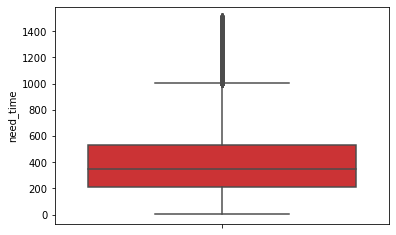

In [117]:
df_train['need_time'] = deal_outliers(df_train, 'need_time')

In [118]:
df_train.head()

,id,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,majorid,label,last_tracking_id,last_action_type,last_time,source_lng,source_lat,target_lng,target_lat,grid_distance,weather_grade,pick_lng,pick_lat,deliver_lng,deliver_lat,create_time,confirm_time,assigned_time,promise_deliver_time,estimate_pick_time,aoi_id,shop_id,level,speed,max_load,train,rush,target_MHD,need_time
0,254012,10515102,0,2100075894604924701,121.523458,39.133308,DELIVERY,1582870205,20200228,2020022810515102_0,1,2100075894604924701,PICKUP,1582869970,121.531154,39.137572,121.529684,39.140121,387.0,4,121.531154,39.137572,121.529684,39.140121,1582869637,1582869637,1582869679,1582871437,1582870537,4b032ad6db2a3132e0e57ff3231f9e24,c3c9ea1f444a997883e432b400507a1d,2,5.677057,10,1,0.185000,0.004019,235
1,47418,110944498,0,2100075352680400741,121.677904,39.069170,DELIVERY,1582163835,20200220,20200220110944498_0,1,2100075352680400741,PICKUP,1582163268,121.678874,39.070310,121.664174,39.069571,1752.0,4,121.678874,39.070310,121.664174,39.069571,1582132586,1582132587,1582162763,1582164900,1582154606,45f00cd55423c4d59156184e0d1193b6,0a2d2d2cd5eb246e6e20294db4cdcc8e,3,5.371323,9,1,0.949496,0.015439,567
2,132140,100069773,5,2100074620752233977,121.559272,39.173702,DELIVERY,1580640942,20200202,20200202100069773_5,1,2100074619659945396,PICKUP,1580640307,121.546490,39.171249,121.552244,39.168591,1295.0,4,121.546034,39.171984,121.552244,39.168591,1580639243,1580639244,1580639275,1580641583,1580640144,5f2f76ca37983e4ac39c3984da6d528f,d00f77a0471afb92e908c9ce93cc8c91,3,4.081472,11,1,0.454701,0.008412,635
3,77922,114244561,4,2100075140308174839,121.361960,39.291729,PICKUP,1581750720,20200215,20200215114244561_4,1,2100075139650553390,DELIVERY,1581750171,121.358704,39.295851,121.362149,39.291649,1564.0,4,121.362149,39.291649,121.336594,39.294171,1581749161,1581749161,1581749533,1581751861,1581750241,e6af011590ed12aadc1f831dd66efee0,3657bc0c499d3328bf0253bd46d1b29f,2,5.815747,7,1,0.374074,0.007647,549
4,117391,118805049,0,2100074587114047221,121.486890,39.136299,DELIVERY,1580604358,20200202,20200202118805049_0,1,2100074587122173405,PICKUP,1580603956,121.492528,39.143660,121.500244,39.153401,1798.0,1,121.487230,39.140461,121.500244,39.153401,1580603199,1580603199,1580603214,1580605599,1580603919,af426a2a8ecd4706e522fb5e0f42f3d7,0fcdb3f0f213c6cf0d6097b496d19b0f,3,4.033038,10,1,0.315417,0.017457,402


In [120]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81567 entries, 0 to 82532
Data columns (total 38 columns):
id                        81567 non-null int64
courier_id                81567 non-null int64
wave_index                81567 non-null int64
tracking_id               81567 non-null object
courier_wave_start_lng    81567 non-null float64
courier_wave_start_lat    81567 non-null float64
action_type               81567 non-null object
expect_time               81567 non-null int64
date                      81567 non-null object
majorid                   81567 non-null object
label                     81567 non-null int64
last_tracking_id          81567 non-null object
last_action_type          81567 non-null object
last_time                 81567 non-null int64
source_lng                81567 non-null float64
source_lat                81567 non-null float64
target_lng                81567 non-null float64
target_lat                81567 non-null float64
grid_distance             8

In [121]:
for f in ['majorid', 'aoi_id', 'shop_id']:
    print(f)
    lbl = LabelEncoder()
    lbl = lbl.fit(df_train[f].astype(str).values.tolist()+df_test[f].astype(str).values.tolist())
    df_train[f] = lbl.transform(df_train[f].astype(str))
    df_test[f] = lbl.transform(df_test[f].astype(str))

majorid
aoi_id
shop_id


In [184]:
prediction = df_test[['courier_id', 'wave_index', 'tracking_id',
                      'courier_wave_start_lng', 'courier_wave_start_lat', 'action_type', 'expect_time', 'date', 'need_time', 'last_time']]
prediction['expect_time'] = 0
prediction['need_time'] = 0

In [185]:
y_col = 'need_time'
x_col = [
    'rush', 'speed', 'max_load', 'weather_grade',# 'level', 
    'grid_distance', 'target_MHD', 'target_lng', 'target_lat', 'source_lng', 'source_lat', 
    'courier_id', 'aoi_id', 'shop_id',
    #'last_time', 'create_time', 'promise_deliver_time', 'estimate_pick_time'
]

model = lgb.LGBMRegressor(num_leaves=64,
                          max_depth=10,
                          learning_rate=0.1,
                          n_estimators=10000000,
                          subsample=0.8,
                          feature_fraction=0.8,
                          reg_alpha=0.5,
                          reg_lambda=0.5,
                          random_state=seed,
                          metric=None
                          )


oof = []
df_importance_list = []

kfold = GroupKFold(n_splits=5)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[x_col], df_train[y_col], df_train['majorid'])):
    X_train = df_train.iloc[trn_idx][x_col]
    Y_train = df_train.iloc[trn_idx][y_col]

    X_val = df_train.iloc[val_idx][x_col]
    Y_val = df_train.iloc[val_idx][y_col]

    print('\nFold_{} Training ================================\n'.format(fold_id+1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=500,
                          eval_metric='mae',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict(
        X_val, num_iteration=lgb_model.best_iteration_)
    df_oof = df_train.iloc[val_idx][['id', y_col]].copy()
    df_oof['pred'] = pred_val
    oof.append(df_oof)

    pred_test = lgb_model.predict(
        df_test[x_col], num_iteration=lgb_model.best_iteration_)
    prediction['need_time'] += pred_test / 5

    df_importance = pd.DataFrame({
        'column': x_col,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    joblib.dump(lgb_model, '../user_data/model_data/modelB_{}.dat'.format(fold_id))
    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()


Fold_1 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	train's l1: 125.489	valid's l1: 145.302

Fold_2 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	train's l1: 123.535	valid's l1: 146

Fold_3 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	train's l1: 123.66	valid's l1: 146.241

Fold_4 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	train's l1: 123.26	valid's l1: 145.531

Fold_5 Training ================================

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	train's l1: 120.266	valid's l1: 144.934


In [186]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg(
    'mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,rush,2448.6
1,shop_id,1765.8
2,speed,1595.4
3,courier_id,1590.6
4,grid_distance,1572.4
5,aoi_id,1498.4
6,target_lat,1438.6
7,target_MHD,1415.8
8,target_lng,1344.2
9,source_lng,1294.4


In [187]:
df_oof = pd.concat(oof)
mae = metrics.mean_absolute_error(df_oof[y_col], df_oof['pred'])
print('mae:', mae)

mae: 145.60161761696668


In [188]:
prediction['expect_time'] = prediction['need_time'] + prediction['last_time']

In [189]:
prediction['expect_time'] = prediction['expect_time'].apply(lambda x: int(x+0.5))

In [190]:
prediction.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,expect_time,date,need_time,last_time
82533,100006950,0,2100076031141348641,121.415380,39.048661,PICKUP,1583032648,20200301,260.276789,1583032388
82534,100023698,0,2100076019384223057,121.370974,39.139544,PICKUP,1583031341,20200301,60.361728,1583031281
82535,100076651,0,2100076028840937366,121.402596,39.191613,PICKUP,1583032173,20200301,15.857825,1583032157
82536,10007871,0,2100076038245615330,121.631349,39.136891,PICKUP,1583035258,20200301,244.271240,1583035014
82537,100100915,0,2100076027963705331,121.528369,39.276954,PICKUP,1583031825,20200301,409.605106,1583031415


In [168]:
prediction.drop(['need_time', 'last_time'], axis=1, inplace=True)

In [169]:
import zipfile
os.makedirs('../sub/{}'.format(int(mae)), exist_ok=True)
f = zipfile.ZipFile('../sub/{}.zip'.format(int(mae)), 'w', zipfile.ZIP_DEFLATED)
for date in prediction['date'].unique():
    df_temp = prediction[prediction['date'] == date]
    del df_temp['date']
    df_temp.to_csv('../sub/{}/action_{}.txt'.format(int(mae), date), index=False)
    f.write('../sub/{}/action_{}.txt'.format(int(mae), date), 'action_{}.txt'.format(date))
f.close()